In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

import poppy as pop
import poputils4comparison as mepop

In [3]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], 'Utils'))
import plot as meplot
sys.path.remove(os.path.join(sys.path[0], 'Utils'))

In [4]:
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['image.origin'] = True

## **Parameters**

In [5]:
wvlgth = 1e-6 #666e-9  

f_nb = 18
diam_obs = 0.3 

diam_aperture = 1.2           
focal_length = f_nb*diam_aperture 

diam_obs = diam_obs/diam_aperture                                 # obscuration ratio
nb_spid = 4                                                  # [m]
spid_width = 0.05                                            # [m]


rad_tel = diam_aperture/2      
focal = f_nb*(2*rad_tel)                                       # for POPPY 
rad_obs = diam_obs/2                                              # obscuration ratio

print('Wavelength = {} m'.format(wvlgth))
print('Aperture = {} m'.format(diam_aperture))
print('Focal length = {x:.3f} m \n'.format(x=focal_length))
print('Fresnel number = {x:.3f}'.format(x=diam_aperture**2/(wvlgth*focal_length)))

Wavelength = 1e-06 m
Aperture = 1.2 m
Focal length = 21.600 m 

Fresnel number = 66666.667


In [6]:
grid_size_pix = 1024
grid_diam = 1.5*diam_aperture

In [7]:
pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)  #It's a computational grid, nothing physical
print('On pupil plane, there is {} m/pix'.format(pupil_grid.delta))  #same as grid_diam/grid_size_pix
print('This is not a real pixel ! This is for the computation\'s sake')

On pupil plane, there is [0.00175953 0.00175953] m/pix
This is not a real pixel ! This is for the computation's sake


## **Aperture Auxtel (spiders + central obscuration)**

#### HCIPy

In [8]:
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

```Python
hci.imshow_field(tel_pupil, cmap='gray')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Aperture')
```

In [9]:
wf = hci.Wavefront(tel_pupil, wvlgth)

#### POPPY

In [10]:
final_ap = mepop.make_aperture(rad_obs, nb_spid, spid_width, rad_tel, showimg=False, rotation=45)

## **Zernike**

#### HCIPy

In [11]:
shift = 0.0001                                   # Longitudinal displacement [m]

F_nb = focal_length/diam_aperture
InPhase = 2*np.pi / wvlgth

nwaves = - shift * InPhase / (8*F_nb**2)
print(nwaves)

-0.24240684055476805


In [12]:
defocus = hci.zernike(2,0)(pupil_grid)  #evaluate zernike poly on the grid 
defocus /= np.ptp(defocus)               #divise par ptp value
defocus *= nwaves                        # ~ replace old defocus ptp value

wf2 = hci.Wavefront(tel_pupil * np.exp(1j * defocus), wvlgth)

#### POPPY

## **Sampling**

To modelise the sampling, the `focal_grid` is used with `sampl_focal` (8 pixels per λ/D)

---
In POPPY, the equivalent is the `osys.add_detector` with a pixel size `pixsize` (0.1 micron)

In [13]:
sampl_focal = 32#8                                  #échantillonage q (8 pix per λ/D) 
hci_fov = 4                                     # [λ/D], radius

focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, hci_fov)

pixsize = 0.01#0.1                                     # Unit: micron/pixel  POPPY 
pop_fov = hci_fov #16.0                                    

print('Sampling at focal = {} pixels per λ/D'.format(sampl_focal))
print('Field of view = {} λ/D'.format(hci_fov))

Sampling at focal = 32 pixels per λ/D
Field of view = 4 λ/D


## **Propagation**

In [14]:
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length)
focal_image = prop.forward(wf)
focal_image2 = prop.forward(wf2)              # Defocused !


psf_1 = mepop.make_psf(final_ap, focal, wvlgth, rad_tel, pixsize, pop_fov,
                     shift=0, showimg=False, logscale=True, showsteps=False)

psf_2 = mepop.make_psf(final_ap, focal, wvlgth, rad_tel, pixsize, pop_fov,
                       shift=shift, showimg=False, logscale=True, showsteps=False)

## **PSF of aperture**

In [15]:
diffwidth2arcsec = 8*(wvlgth/diam_aperture)* (180*3600/np.pi)

print('HCIPY \n 1 λ/D = {} arcsec = {} pixels'.format(diffwidth2arcsec, sampl_focal))
print('8 pixel = {} arcsec'.format(8*diffwidth2arcsec/sampl_focal))

HCIPY 
 1 λ/D = 1.3750987083139758 arcsec = 32 pixels
8 pixel = 0.34377467707849396 arcsec


HCIPY 



/home/max/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


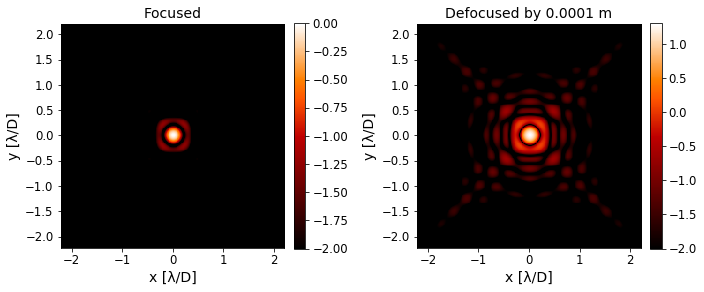

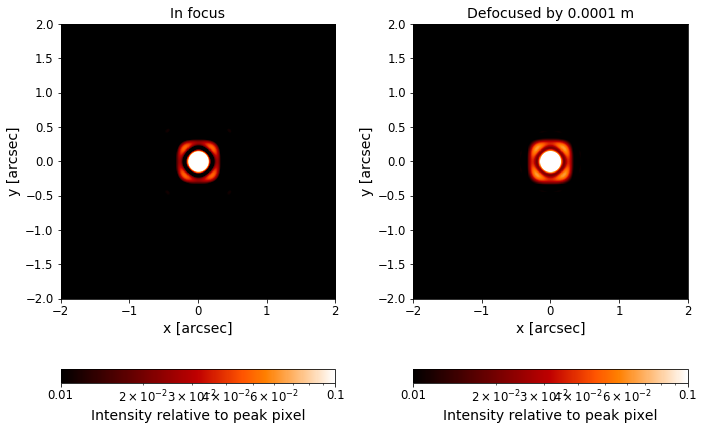

In [16]:
print('HCIPY \n')
plt.subplot(1, 2, 1)
hci.imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()),cmap='gist_heat' , vmin=-2) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Focused')

plt.subplot(1, 2, 2)
hci.imshow_field(np.log10(focal_image2.intensity),cmap='gist_heat', vmin=-2) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Defocused by {} m'.format(shift))

#plt.savefig('HCIPy_fov_VS_defoc.jpg')
plt.tight_layout()
plt.show()


#print('POPPY \n 1 pixel = {} arcsec '.format(pixsize/2))

mepop.foc_VS_defoc_img(psf_1, psf_2, shift, 
                     logscale=True, normalised=True)#, saveit=True)

## **PSF in 2D (slice or sum)**

### HCIPy

In [17]:
hci_int_map_1 = focal_image.intensity.shaped   # focus                  # Take intensity and reshape (1D -> 2D)
hci_int_map_2 = focal_image2.intensity.shaped  # defocus      

hci_xaxis_1 = focal_grid.x.reshape(hci_int_map_1.shape)[0,:]*0.95
hci_xaxis_2 = focal_grid.x.reshape(hci_int_map_2.shape)[0,:]*0.95

meplot.slicum_for_focdefoc(hci_int_map_1, hci_int_map_2, hci_xaxis_1, hci_xaxis_2, 
                      logscale=True, normalised=True, ymin=10**-2, xmin=-1, xmax=1) #ymin, xmin, xmax

meplot.foc_VS_defoc(hci_int_map_1/hci_int_map_1.max(), hci_int_map_2/hci_int_map_1.max(), hci_xaxis_1, hci_xaxis_2, 
                  logscale=True, normalised=False, wantslice=True, ymin=10**-2, xmin=-1, xmax=1)
plt.savefig('HCIPy_fov_VS_defoc_graph_0,003')

### POPPY

In [18]:
pop_int_map_1 = psf_1[0].data  # focus
pop_int_map_2 = psf_2[0].data  # defocus

halffov_x_1 = pixsize * pop_int_map_1.shape[1] / 2.0  
pop_xaxis_1 = np.linspace(-halffov_x_1,halffov_x_1,np.shape(pop_int_map_1)[1])

halffov_x_2 = pixsize * pop_int_map_2.shape[1] / 2.0  
pop_xaxis_2 = np.linspace(-halffov_x_2,halffov_x_2,np.shape(pop_int_map_2)[1])

meplot.slicum_for_focdefoc(pop_int_map_1, pop_int_map_2, pop_xaxis_1/2, pop_xaxis_2/2, 
                      logscale=True, normalised=True, ymin=10**-2, xmin=-1, xmax=1)

meplot.foc_VS_defoc(pop_int_map_1/pop_int_map_1.max(), pop_int_map_2/pop_int_map_1.max(), pop_xaxis_1/2, pop_xaxis_2/2, 
                  logscale=True, normalised=False, wantslice=True, ymin=10**-2, xmin=-1, xmax=1)

#plt.savefig('POPPY_fov_VS_defoc_graph_0,0005')

# Comparison

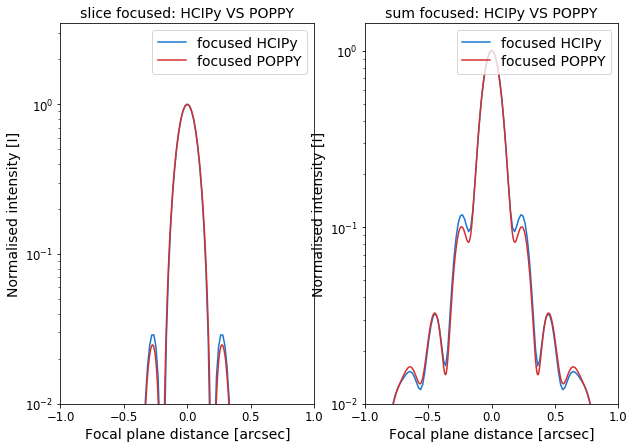

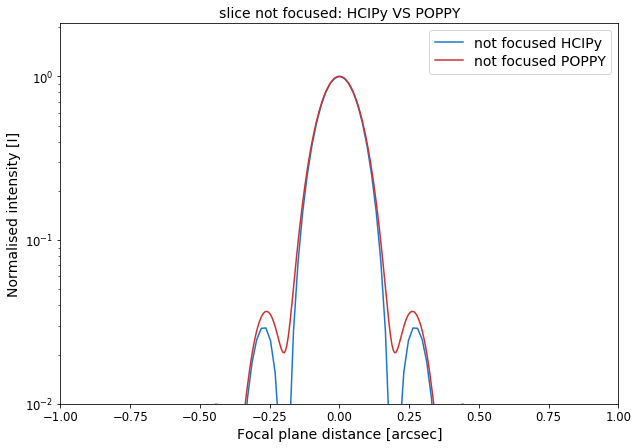

In [19]:
meplot.HCIPy_vs_POPPY2(hci_int_map_1, pop_int_map_1, hci_xaxis_1, pop_xaxis_1/2, focused=True,  #PUT IT IN SAME UNIT
                  logscale=True, normalised=True, ymin=10**-2, xmin=-1, xmax=1)
#plt.savefig('HCIPy_vs_POPPY_foc_graph_cheat')

meplot.HCIPy_vs_POPPY(hci_int_map_2, pop_int_map_2, hci_xaxis_2, pop_xaxis_2/2, focused=False,
                  logscale=True, normalised=True, wantslice=True, ymin=10**-2, xmin=-1, xmax=1)
#plt.savefig('HCIPy_vs_POPPY_defoc_graph')